In [7]:
import os
import numpy as np
import librosa
import librosa.display
from pathlib import Path
import matplotlib.pyplot as plt
import scipy

## Re-cap
### Overlap-add convolution

In [8]:
L = 31        # FIR filter length in taps
fc = 600      # lowpass cutoff frequency in Hz
fs = 4000     # sampling rate in Hz

Nsig = 150    # signal length in samples
period = L//3 # signal period in samples
print('Period of the signal is {}'.format(period))

Period of the signal is 10


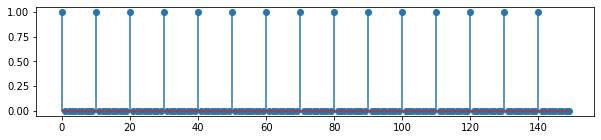

In [9]:
M = L                  # nominal window length
Nfft = 2**(np.ceil(np.log2(M+L-1))) # FFT Length
M = Nfft-L+1            # efficient window length
R = M                  # hop size for rectangular window
Nframes = 1+np.floor((Nsig-M)/R)  # no. complete frames
tn = np.arange(0,Nsig)
# Generate Impulse train signal
sig = np.zeros((Nsig,))
for p in np.arange(0,Nsig,period):
    sig[p] = 1
    
plt.figure(figsize=(10, 2))
plt.stem(tn,sig)
plt.show()

# Low-pass filter using hamming window
epsilon = .0001;     # avoids 0 / 0
nfilt = np.arange(-(L)/2,(L)/2) + epsilon
hideal = np.sin(2*np.pi*fc*nfilt/fs) / (np.pi*nfilt)
w = np.hamming(L) # FIR filter design by window method
h = w.T * hideal # window the ideal impulse response
hzp = np.zeros( (int(len(h)+(Nfft-L)),) )
hzp[:len(h)] = h  # zero-pad h to FFT size
H = scipy.fft.fft(hzp)      #filter frequency response


index 0.0-34.0


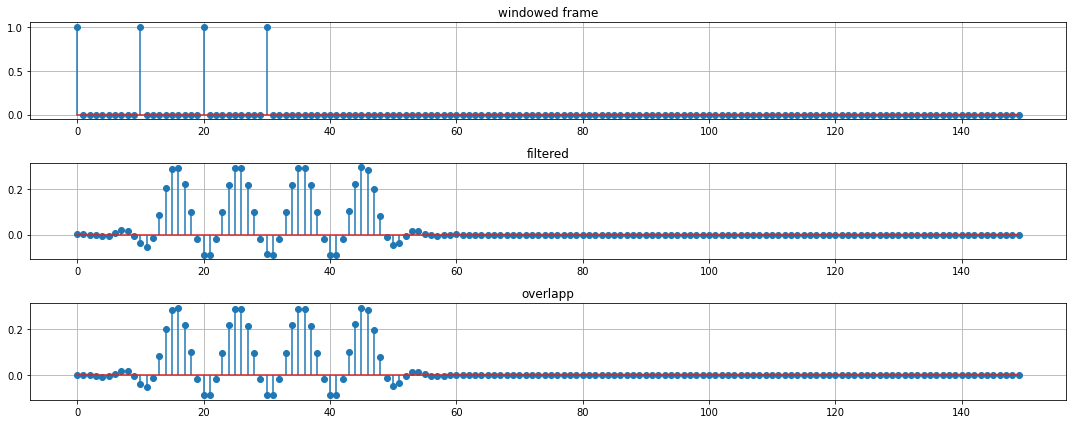

index 34.0-68.0


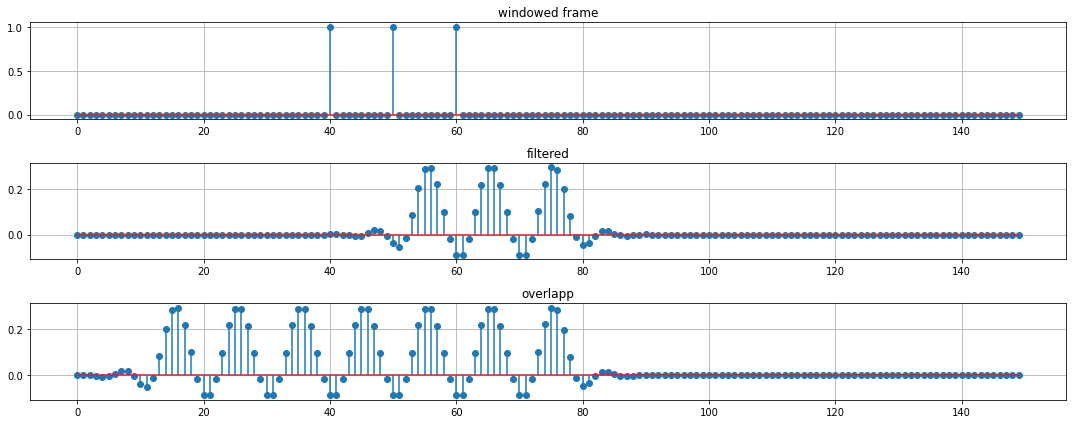

index 68.0-102.0


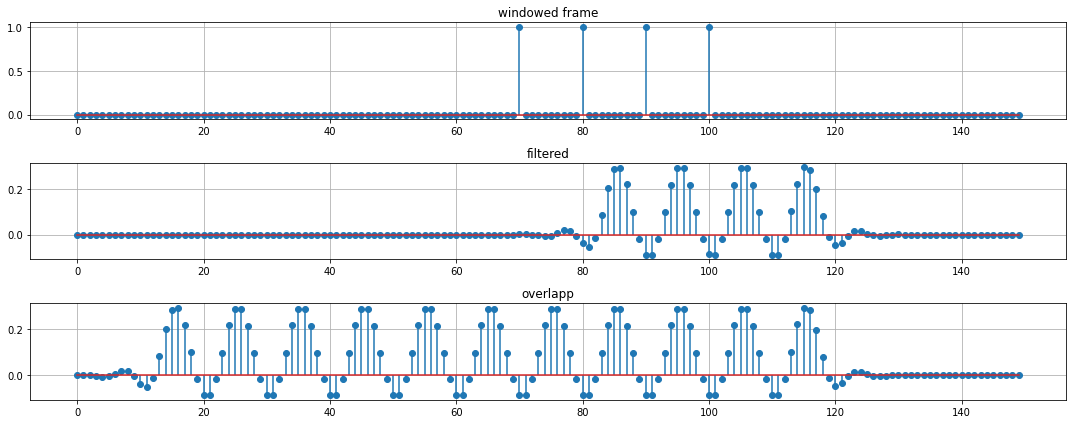

In [10]:
y = np.zeros((int(Nsig + Nfft),)) # allocate output+'ringing' vector
for m in range(0,int(Nframes)-1):
    
    
    print('index {}-{}'.format(m*R, np.min((m*R+M,Nsig)) ))
    xm = sig[int(m*R):int(np.min((m*R+M,Nsig)))] # windowed mth frame (rectangular window)
    xmzp = np.zeros((int(len(xm)+(Nfft-len(xm))),))
    xmzp[:len(xm)] = xm  # zero pad the signal
    
    Xm = scipy.fft.fft(xmzp)
    Ym = Xm * H;               # freq domain multiplication
    ym = np.real(scipy.fft.ifft(Ym))         # inverse transform

    y[int(m*R):int(m*R+Nfft)] = y[int(m*R):int(m*R+Nfft)] + ym # overlap add
    
   
    fig, ax = plt.subplots(3,1,figsize=(15, 6))
    
    aux = np.zeros((int(Nsig),))
    aux[int(m*R):int(m*R+Nfft)] = xmzp
    ax[0].stem(aux)
    ax[0].set_title('windowed frame')
    ax[0].grid()
    
    aux = np.zeros((int(Nsig),))
    aux[int(m*R):int(m*R+Nfft)] = ym
    ax[1].stem(aux)
    ax[1].set_title('filtered')
    ax[1].grid()
    ax[2].stem(y[:Nsig])
    ax[2].set_title('overlapp')
    ax[2].grid()
    
    fig.tight_layout()
    plt.show()

**Note**: frames 0 and 2 contain four impulses, while frame 1 only happens to catch three; this causes no difficulty, and the filtered result remains correct by superposition.

### Time-domain feature extraction

In [13]:
kick_signals = [librosa.load(os.fspath(p))[0] for p in Path().glob('audio/test/kick_*.mp3')]
snare_signals = [librosa.load(os.fspath(p))[0] for p in Path().glob('audio/test/snare_*.mp3')]

In [14]:
print('{} kick signals - {} snare signals'.format(len(kick_signals),len(snare_signals)))

4 kick signals - 4 snare signals


Kick drum signals

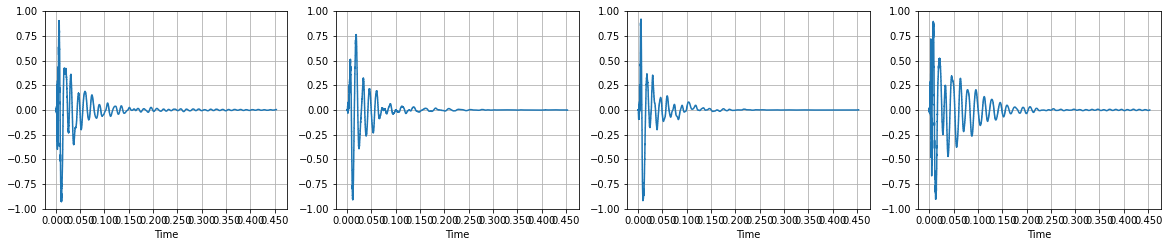

In [15]:
plt.figure(figsize=(20, 8))
for i, x in enumerate(kick_signals):
    plt.subplot(2, 4, i+1)
    librosa.display.waveshow(x[:10000])
    plt.ylim(-1, 1)
    plt.grid()

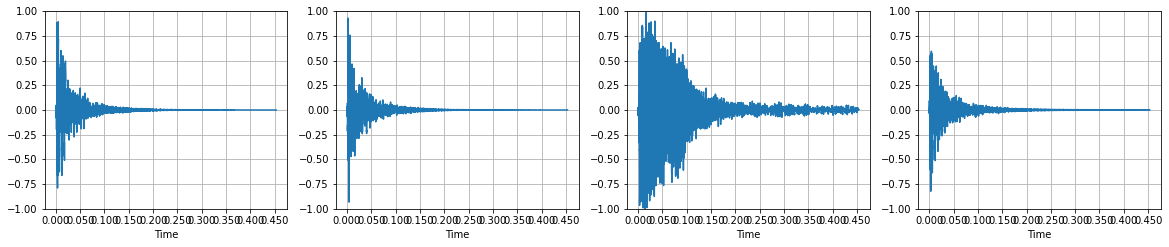

In [16]:
plt.figure(figsize=(20, 8))
for i, x in enumerate(snare_signals):
    plt.subplot(2, 4, i+1)
    librosa.display.waveshow(x[:10000])
    plt.ylim(-1, 1)
    plt.grid()

### Function to extract two features from both types of signals.

In [17]:
def extract_features(signal):
    return [
        librosa.feature.zero_crossing_rate(y=signal)[0, 0],
        librosa.feature.spectral_centroid(y=signal)[0, 0],
    ]

In [18]:
kick_features = np.array([extract_features(x) for x in kick_signals])
snare_features = np.array([extract_features(x) for x in snare_signals])

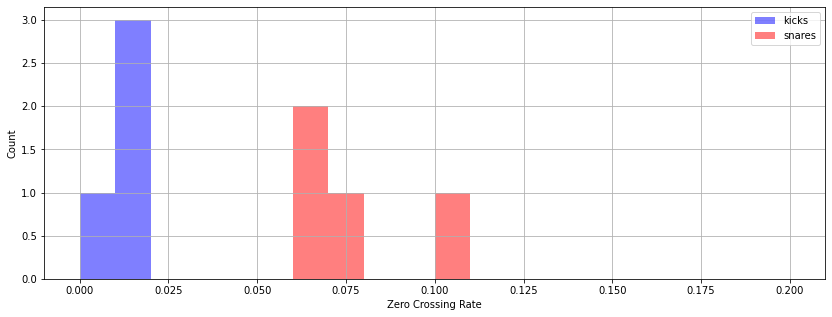

In [19]:
plt.figure(figsize=(14, 5))
plt.hist(kick_features[:,0], color='b', range=(0, 0.2), alpha=0.5, bins=20)
plt.hist(snare_features[:,0], color='r', range=(0, 0.2), alpha=0.5, bins=20)
plt.legend(('kicks', 'snares'))
plt.xlabel('Zero Crossing Rate')
plt.ylabel('Count')
plt.grid()

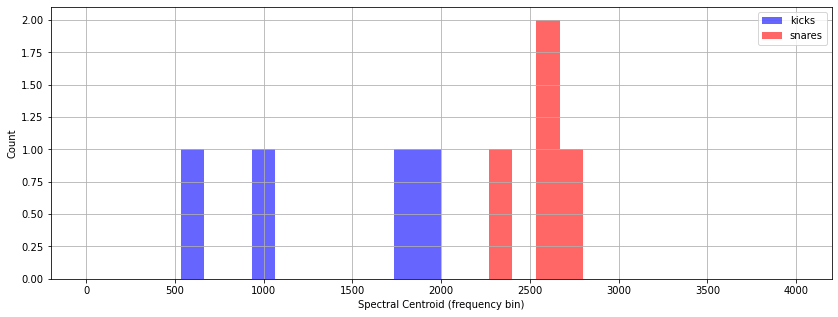

In [20]:
plt.figure(figsize=(14, 5))
plt.hist(kick_features[:,1], color='b', range=(0, 4000), bins=30, alpha=0.6)
plt.hist(snare_features[:,1], color='r', range=(0, 4000), bins=30, alpha=0.6)
plt.legend(('kicks', 'snares'))
plt.xlabel('Spectral Centroid (frequency bin)')
plt.ylabel('Count')
plt.grid()

#### We concatenate the two feature vectors to construct a feature matrix 

In [21]:
feature_table = np.vstack((kick_features, snare_features))
print(feature_table.shape)


(8, 2)


In [23]:
feature_table[:,0] = feature_table[:,0]/feature_table[:,0].max()
feature_table[:,1] = feature_table[:,1]/feature_table[:,1].max()

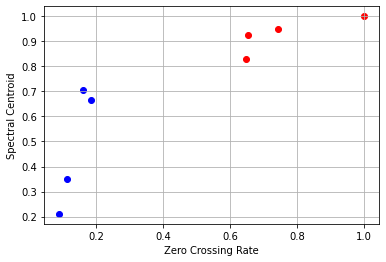

In [28]:
plt.scatter(feature_table[:4,0], feature_table[:4,1], c='b')
plt.scatter(feature_table[4:,0], feature_table[4:,1], c='r')
plt.xlabel('Zero Crossing Rate')
plt.ylabel('Spectral Centroid')
plt.grid()